In [3]:
# Specify inline plots for notebook
%matplotlib inline
from matplotlib.font_manager import FontProperties

# Libraries -- overkill for the time being
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime

# Set working dir
wrkDir = 'C:/Research/AGU_2015/'


In [21]:
113 - 81

32

In [62]:
VCM = pd.read_csv(wrkDir + 'VCM.csv')
VCMNDVI = VCM[VCM.Band == '250m_16_days_NDVI']
VCMNDVI['Date'] = VCMNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
VCMNDVI.index = VCMNDVI['Date']

VCP = pd.read_csv(wrkDir + 'VCM.csv')
VCPNDVI = VCP[VCP.Band == '250m_16_days_NDVI']
VCPNDVI['Date'] = VCPNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
VCPNDVI.index = VCMNDVI['Date']

MPJ = pd.read_csv(wrkDir + 'MPJ.csv')
MPJNDVI = MPJ[MPJ.Band == '250m_16_days_NDVI']
MPJNDVI['Date'] = MPJNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
MPJNDVI.index = MPJNDVI['Date']

WJS = pd.read_csv(wrkDir + 'JSAV.csv')
WJSNDVI = WJS[WJS.Band == '250m_16_days_NDVI']
WJSNDVI['Date'] = WJSNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
WJSNDVI.index = WJSNDVI['Date']

SES = pd.read_csv(wrkDir + 'SES.csv')
SESNDVI = SES[SES.Band == '250m_16_days_NDVI']
SESNDVI['Date'] = SESNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
SESNDVI.index = SESNDVI['Date']

SEG = pd.read_csv(wrkDir + 'SEG.csv')
SEGNDVI = SEG[SEG.Band == '250m_16_days_NDVI']
SEGNDVI['Date'] = SEGNDVI['Date'].map(lambda x: x.lstrip('A').rstrip('aAbBcC'))
SEGNDVI.index = SEGNDVI['Date']


test = pd.date_range('20000305',periods=310, freq = '16D')

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

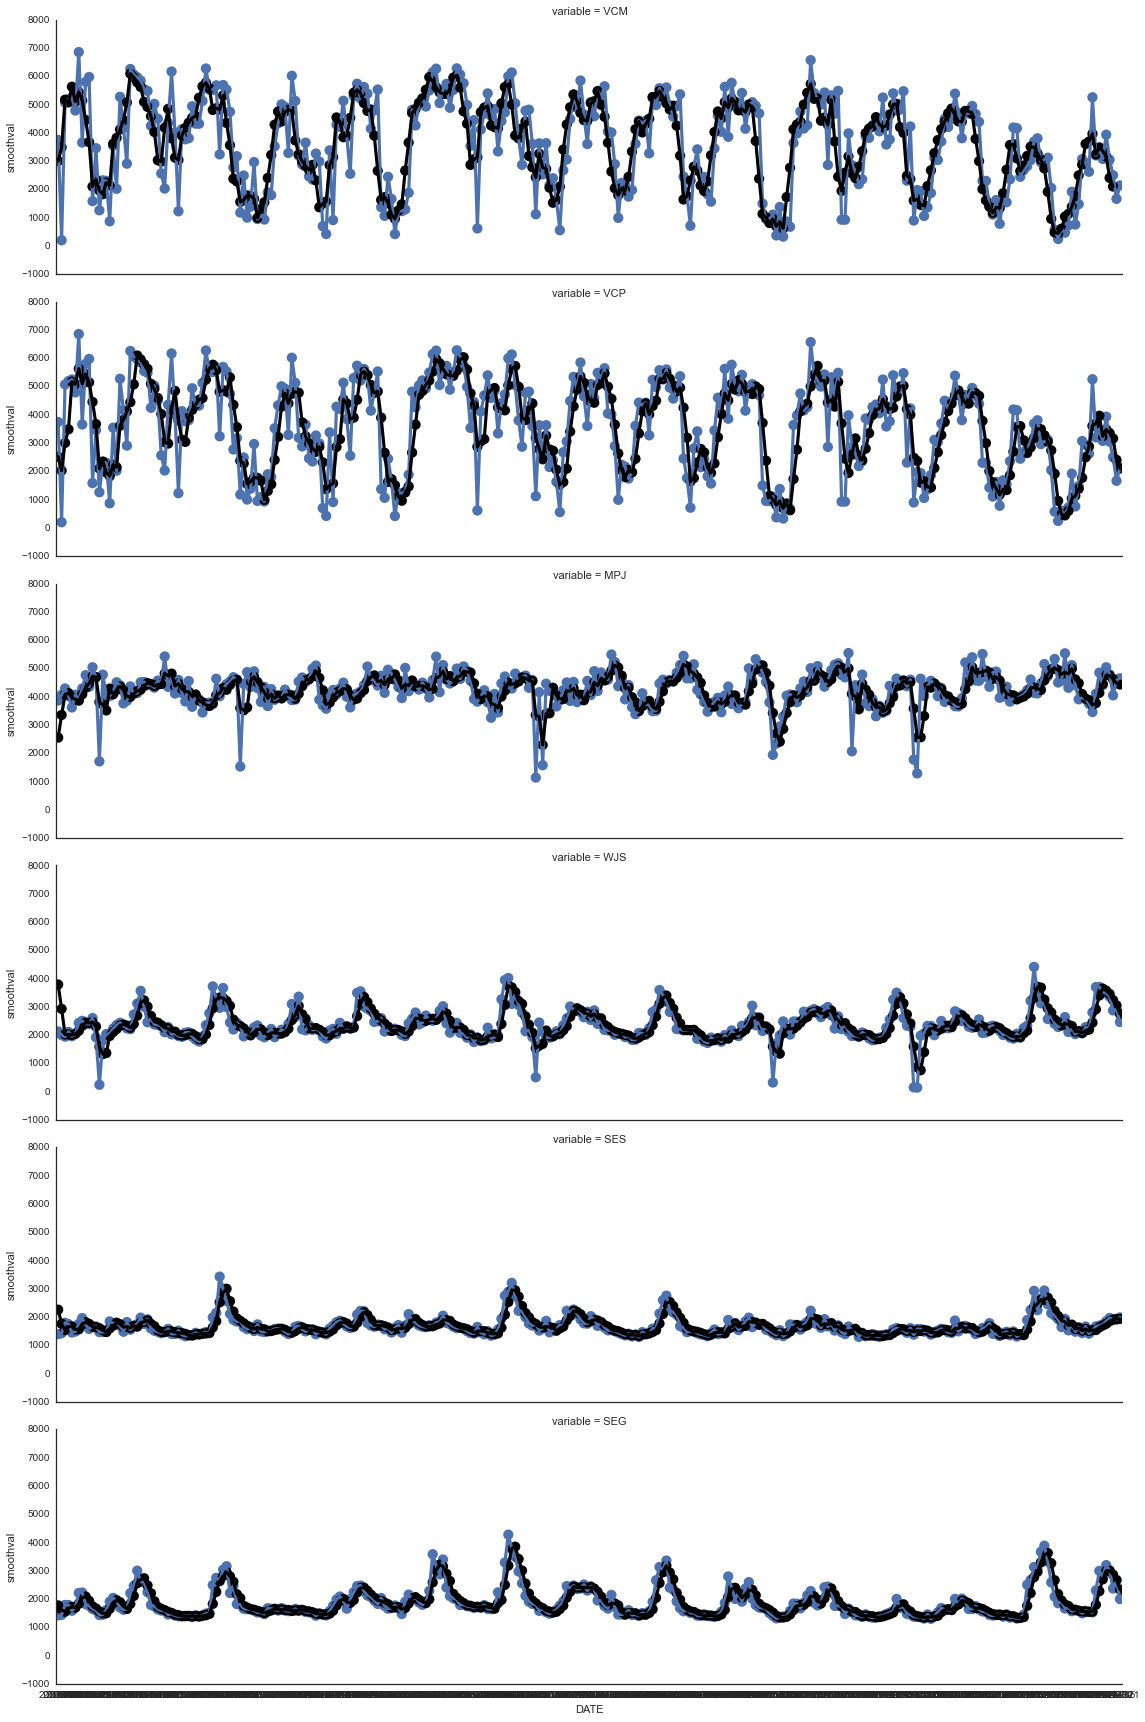

In [87]:
VCMNDVI.index = VCMNDVI['Date']

MODIS_NDVI = pd.DataFrame(dict(DATE = VCMNDVI.Date,
                               VCM = VCMNDVI['397'], VCP = VCPNDVI['397'],
                               MPJ = MPJNDVI['397'], WJS = WJSNDVI['397'],
                               SES = SESNDVI['397'], SEG = SEGNDVI['397']), index = VCMNDVI.index)

NMEG_NDVI = pd.melt(MODIS_NDVI, id_vars='DATE', value_vars=['VCM','VCP','MPJ','WJS','SES','SEG'])
NMEG_rollmean = pd.rolling_mean(NMEG_NDVI.value, 3)
NMEG_NDVI['smoothval'] = NMEG_rollmean
order = list(['VCM','VCP','MPJ','WJS','SES','SEG'])
sns.set_style('white')

g = sns.FacetGrid(NMEG_NDVI, row="variable", row_order=order,
                  size=4, aspect=4,)
g.map(sns.pointplot, "DATE",  "value", lw = 0.1);
g.map(sns.pointplot, "DATE",  "smoothval", lw = 0.05, color = 'black');

